In [1]:
from sklearn.datasets import make_classification
import pandas as pd

# Create a synthetic imbalanced dataset with 1000 samples, 10 features, and 5% positive class
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, 
                           weights=[0.95, 0.05], random_state=42)

# Convert to DataFrame for easy manipulation
data = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(1, 11)])
data['Target'] = y

data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Target
0,0.964799,-0.066449,0.986768,-0.358079,0.997266,1.181890,-1.615679,-1.210161,-0.628077,1.227274,0
1,1.230350,-0.566395,1.169487,0.831617,-1.176962,1.820544,-1.788927,-0.984534,-1.091341,0.209470,0
2,0.969347,-0.432774,0.858089,0.793818,-0.268646,-1.836360,-1.216083,-0.246383,-1.066667,-0.297376,0
3,1.750412,2.023606,1.688159,0.006800,-1.607661,0.184741,-2.619427,-0.357445,-1.473127,-0.190039,0
4,-0.001184,-0.711303,0.208114,0.117124,1.536061,0.597538,-0.637329,-0.939156,0.684698,0.236224,0


In [2]:
# Show the class distribution
print(data['Target'].value_counts(normalize=True))

Target
0    0.947
1    0.053
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop(columns=['Target'])
y = data['Target']

# Split the dataset into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions on train and test sets
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Confusion Matrix, Classification Report, and AUC score for Training Set
print("Training Set:")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
train_auc = roc_auc_score(y_train, rf_classifier.predict_proba(X_train)[:, 1])
print("AUC Score (Train):", train_auc)

# Confusion Matrix, Classification Report, and AUC score for Testing Set
print("\nTesting Set:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
test_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print("AUC Score (Test):", test_auc)

Training Set:
[[663   0]
 [  0  37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00        37

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

AUC Score (Train): 1.0

Testing Set:
[[282   2]
 [ 11   5]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       284
           1       0.71      0.31      0.43        16

    accuracy                           0.96       300
   macro avg       0.84      0.65      0.71       300
weighted avg       0.95      0.96      0.95       300

AUC Score (Test): 0.9043794014084507


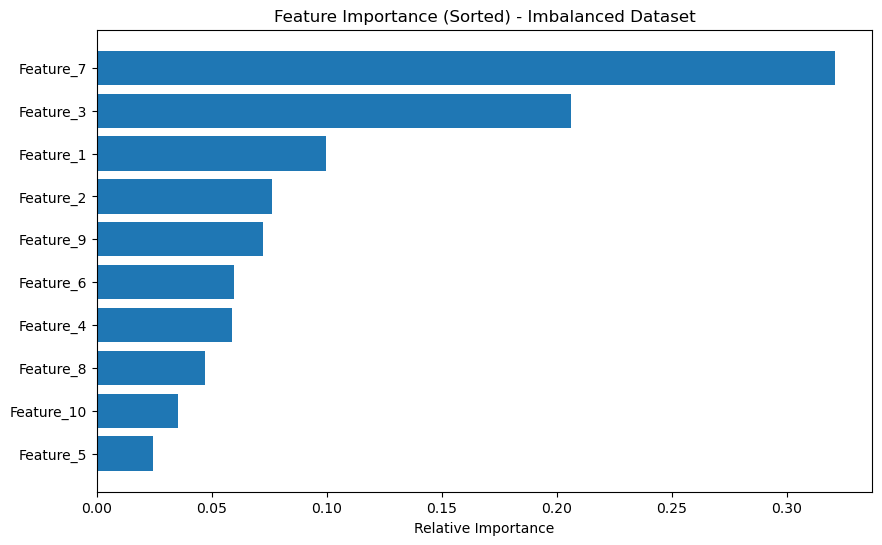

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the model
importances = rf_classifier.feature_importances_
features = X.columns

# Sort features by importance in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances in descending order
plt.figure(figsize=(10,6))
plt.title("Feature Importance (Sorted) - Imbalanced Dataset")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

In [7]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                               n_iter=10, cv=3, random_state=42, n_jobs=-1)

# Fit the randomized search model
rf_random.fit(X_train, y_train)

# Best parameters from the search
print("Best Parameters:", rf_random.best_params_)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'class_weight': 'balanced_subsample'}


In [8]:
# Initialize the Random Forest Classifier with tuned hyperparameters
rf_classifier_optimized = rf_random.best_estimator_

# Train the optimized model
rf_classifier_optimized.fit(X_train, y_train)

# Evaluate the optimized model
y_train_pred_optimized = rf_classifier_optimized.predict(X_train)
y_test_pred_optimized = rf_classifier_optimized.predict(X_test)

# Confusion Matrix and AUC for the optimized model - Training Set
print("Optimized Training Set:")
print(confusion_matrix(y_train, y_train_pred_optimized))
print(classification_report(y_train, y_train_pred_optimized))
train_auc_optimized = roc_auc_score(y_train, rf_classifier_optimized.predict_proba(X_train)[:, 1])
print("AUC Score (Train - Optimized):", train_auc_optimized)

# Confusion Matrix and AUC for the optimized model - Testing Set
print("\nOptimized Testing Set:")
print(confusion_matrix(y_test, y_test_pred_optimized))
print(classification_report(y_test, y_test_pred_optimized))
test_auc_optimized = roc_auc_score(y_test, rf_classifier_optimized.predict_proba(X_test)[:, 1])
print("AUC Score (Test - Optimized):", test_auc_optimized)

Optimized Training Set:
[[663   0]
 [  0  37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00        37

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

AUC Score (Train - Optimized): 1.0

Optimized Testing Set:
[[280   4]
 [  9   7]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       284
           1       0.64      0.44      0.52        16

    accuracy                           0.96       300
   macro avg       0.80      0.71      0.75       300
weighted avg       0.95      0.96      0.95       300

AUC Score (Test - Optimized): 0.8993177816901409
